In [1]:
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import torch
import numpy as np
import multimolecule
import os
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from metric_utils import plot_training_history
import seaborn as sns 
import matplotlib.pyplot as plt



In [2]:
train_data_path = os.path.join('..', 'data', 'labeled', 'train_labeled.csv')
val_data_path = os.path.join('..', 'data', 'labeled', 'val_labeled.csv')

df_train = pd.read_csv(train_data_path)
df_train = df_train.rename(columns={'entropy_log':'log_entropy'})

df_val = pd.read_csv(val_data_path)

df_train = df_train[~((df_train['x_1'] == -1e18) | 
                      (df_train['y_1'] == -1e18) | 
                      (df_train['z_1'] == -1e18))]

df_val = df_val[~((df_val['x_1'] == -1e18) | 
                  (df_val['y_1'] == -1e18) | 
                  (df_val['z_1'] == -1e18))]


In [3]:
tokenizer = AutoTokenizer.from_pretrained('multimolecule/rnabert')
model = AutoModel.from_pretrained('multimolecule/rnabert')
model.eval() 

RnaBertModel(
  (embeddings): RnaBertEmbeddings(
    (word_embeddings): Embedding(26, 120, padding_idx=0)
    (position_embeddings): Embedding(440, 120)
    (token_type_embeddings): Embedding(2, 120)
    (layer_norm): RnaBertLayerNorm()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): RnaBertEncoder(
    (layer): ModuleList(
      (0-5): 6 x RnaBertLayer(
        (attention): RnaBertAttention(
          (self): RnaBertSelfAttention(
            (query): Linear(in_features=120, out_features=120, bias=True)
            (key): Linear(in_features=120, out_features=120, bias=True)
            (value): Linear(in_features=120, out_features=120, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): RnaBertSelfOutput(
            (dense): Linear(in_features=120, out_features=120, bias=True)
            (layer_norm): RnaBertLayerNorm()
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): RnaBertI

In [11]:
def compute_tm_score(y_true, y_pred):

    L_ref = y_true.shape[0]

    # Evitamos división por cero explícitamente
    if L_ref == 0:
        return 0.0

    # Correcto manejo de d0 según la definición
    if L_ref >= 30:
        d0 = 0.6 * np.sqrt(L_ref - 0.5) - 2.5
    elif L_ref < 12:
        d0 = 0.3
    elif 12 <= L_ref <= 15:
        d0 = 0.4
    elif 16 <= L_ref <= 19:
        d0 = 0.5
    elif 20 <= L_ref <= 23:
        d0 = 0.6
    elif 24 <= L_ref <= 29:
        d0 = 0.7

    distances = np.linalg.norm(y_true - y_pred, axis=1)

    tm_score = (1 / L_ref) * np.sum(1 / (1 + (distances / d0) ** 2))

    return tm_score

class TMScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train, X_val, y_val):
        super().__init__()
        self.X_train, self.y_train = X_train, y_train
        self.X_val, self.y_val = X_val, y_val
        self.train_tm_history, self.val_tm_history = [], []

    def compute_tm_for_dataset(self, X, y_true):
        y_pred = self.model.predict(X, verbose=0)
        scores = []
        for true_seq, pred_seq in zip(y_true, y_pred):
            valid_length = np.sum(np.any(true_seq != 0, axis=-1))
            
            if valid_length == 0:  # evitar secuencias vacías
                continue
                
            scores.append(compute_tm_score(true_seq[:valid_length], pred_seq[:valid_length]))

        return np.mean(scores) if scores else 0.0

    def on_epoch_end(self, epoch, logs=None):
        train_tm = self.compute_tm_for_dataset(self.X_train, self.y_train)
        val_tm = self.compute_tm_for_dataset(self.X_val, self.y_val)

        self.train_tm_history.append(train_tm)
        self.val_tm_history.append(val_tm)

        print(f"\nEpoch {epoch+1} - TM-score: Train: {train_tm:.6f}, Val: {val_tm:.6f}")

    def plot_tm_score(self):
        epochs = range(1, len(self.train_tm_history) + 1)
        tm_df = pd.DataFrame({
            'Epoch': epochs,
            'Train TM-score': self.train_tm_history,
            'Validation TM-score': self.val_tm_history
        })
    
        plt.figure(figsize=(15, 5), dpi=300)
        sns.lineplot(x='Epoch', y='Train TM-score', data=tm_df, marker='o', color='#118AB2', label='Entrenamiento')
        sns.lineplot(x='Epoch', y='Validation TM-score', data=tm_df, marker='o', color='#FF220C', label='Validación')
    
        plt.title('Evolución del TM-score por época', fontsize=16, fontweight='bold', pad=15)
        plt.xlabel('Época', fontsize=13)
        plt.ylabel('TM-score', fontsize=13)
        plt.grid(True)
        plt.legend()
        sns.despine()
        plt.tight_layout()
        plt.show()

def build_conv1d_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Masking(mask_value=0.0)(inputs)

    x = layers.Conv1D(128, 7, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(128, 5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    outputs = layers.Conv1D(3, 1)(x)

    model = models.Model(inputs, outputs)
    return model

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_transformer_model(input_shape, num_transformer_blocks=2, head_size=128, num_heads=4, ff_dim=256, dropout=0.1):
    inputs = layers.Input(shape=input_shape)
    x = layers.Masking(mask_value=0.0)(inputs)

    x = layers.Conv1D(128, kernel_size=1, activation='relu')(x)

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Refinamiento final con Conv1D adicional
    x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    outputs = layers.Conv1D(3, 1)(x)

    model = models.Model(inputs, outputs)
    return model



In [5]:
def get_embeddings(sequence, tokenizer, model, max_len=440):
    tokens = tokenizer(sequence, return_tensors='pt', 
                       truncation=True,  # trunca a la máxima longitud permitida
                       max_length=max_len)
    with torch.no_grad():
        outputs = model(**tokens)
    embeddings = outputs.last_hidden_state.squeeze(0).numpy()
    return embeddings

In [9]:
embeddings_dict = {}
for seq_id in df_train['sequence_id'].unique():
    seq_df = df_train[df_train['sequence_id'] == seq_id]
    sequence = ''.join(seq_df['nucleotide'].values)
    embeddings_dict[seq_id] = get_embeddings(sequence, tokenizer, model)

In [6]:
def prepare_input_output(df, embeddings_dict):
    X, y = [], []
    
    grouped = df.groupby('sequence_id')
    for seq_id, group in grouped:
        
        emb = embeddings_dict[seq_id]  # embeddings RNABert (len_seq, 120)
        extra_feats = group[['relative_position', 'log_entropy']].values  # (len_seq, 2)

        # Asegúrate de truncar extra_feats al mismo largo que emb
        min_len = min(len(emb), len(extra_feats))
        emb = emb[:min_len]
        extra_feats = extra_feats[:min_len]

        # Concatenamos embeddings y features adicionales
        combined_feats = np.concatenate([emb, extra_feats], axis=1)  # (len_seq, 122)
        
        # Output: coordenadas x_1, y_1, z_1
        coords = group[['x_1', 'y_1', 'z_1']].values[:min_len]  # (len_seq, 3)

        # Guardamos en listas
        X.append(combined_feats)
        y.append(coords)

    # Padding para manejar diferentes largos de secuencias
    X_padded = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', dtype='float32')
    y_padded = tf.keras.preprocessing.sequence.pad_sequences(y, padding='post', dtype='float32')

    return X_padded, y_padded

In [8]:
X, y = prepare_input_output(df_train, embeddings_dict)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
y_train = np.nan_to_num(y_train, nan=0.0, posinf=0.0, neginf=0.0)

X_val = np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0)
y_val = np.nan_to_num(y_val, nan=0.0, posinf=0.0, neginf=0.0)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)

NameError: name 'embeddings_dict' is not defined

In [19]:
input_shape = X_train.shape[1:]  # (max_len_seq, 122)
model = build_conv1d_model(input_shape)
model.compile(optimizer='adam', loss='mape')

model.summary()


/Users/rospel/anaconda3/envs/Project1/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_10' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 440, 122)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masking_1 (Masking)             │ (None, 440, 122)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 440, 128)       │       109,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 440, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 440, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 440, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 440, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 440, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 440, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 440, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 440, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 440, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 440, 3)         │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 416,131 (1.59 MB)

 Trainable params: 414,723 (1.58 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [20]:
tm_callback = TMScoreCallback(X_train, y_train, X_val, y_val)
history = model.fit(
    X_train, y_train,
    epochs=100, batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[tm_callback, tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

Epoch 1/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 230069168.0000
Epoch 1 - TM-score: Train: 0.031218, Val: 0.044814
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 225328336.0000 - val_loss: 66403000.0000
Epoch 2/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 38493772.0000
Epoch 2 - TM-score: Train: 0.028230, Val: 0.040577
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 38279364.0000 - val_loss: 106903432.0000
Epoch 3/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 22634412.0000
Epoch 3 - TM-score: Train: 0.027590, Val: 0.040339
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 22624252.0000 - val_loss: 270827712.0000
Epoch 4/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 21728532.0000
Epoch 4 - TM-score: Train: 0.025827, Val: 0.040117
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 21793510.0000 - val_loss: 314069856.0000
Epoch 5/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 20817138.0000
Epoch 5 - TM-score: Train: 0.025039, Val: 0.038140
42/42 ━━━━━━━━━━━━

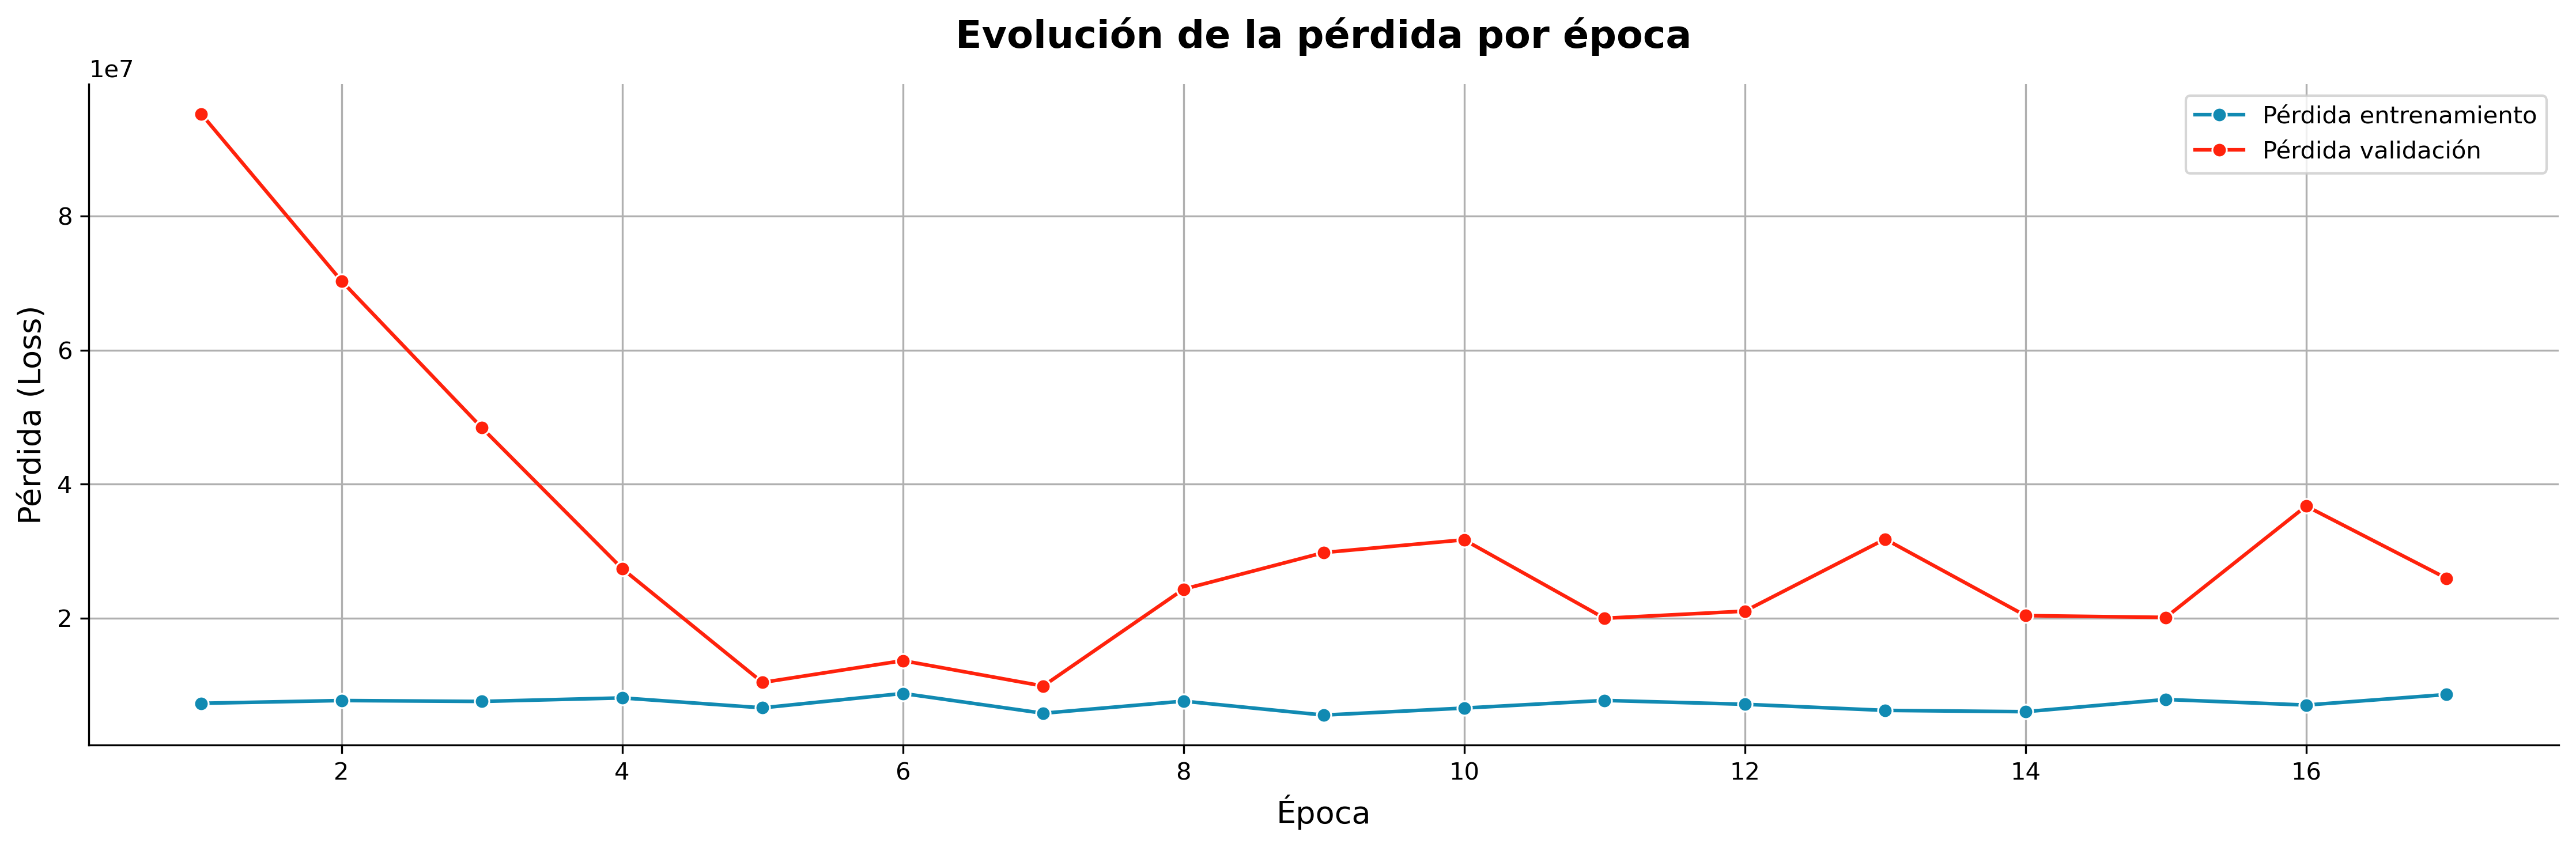

In [14]:
plot_training_history(history)

In [21]:
max(tm_callback.val_tm_history)

0.044813749488186394

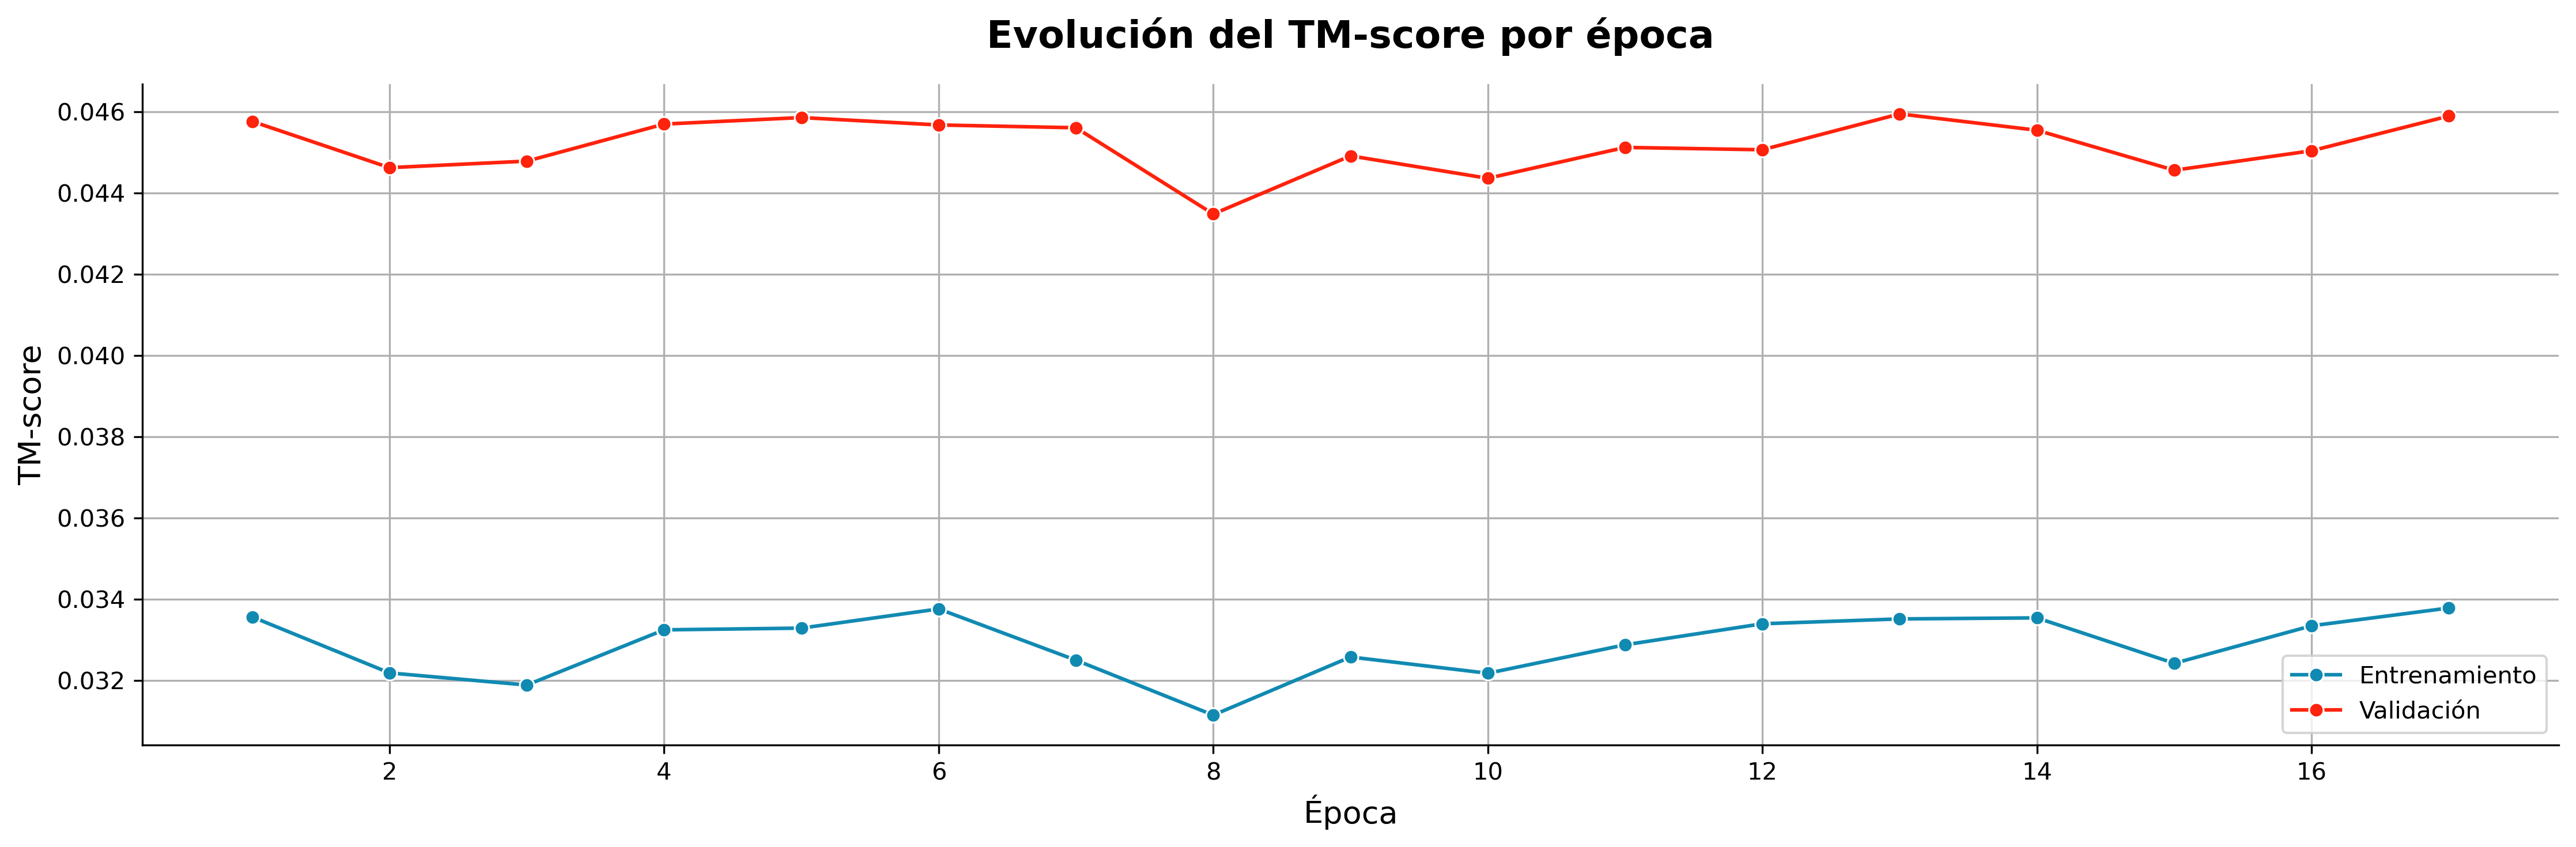

In [17]:
tm_callback.plot_tm_score()

In [12]:
model = build_transformer_model(input_shape=X_train.shape[1:], num_transformer_blocks=3)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mape')
model.summary()

/Users/rospel/anaconda3/envs/Project1/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 440, 122)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 440, 122)  │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 440, 128)  │     15,744 │ masking[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 440, 128)  │        256 │ conv1d[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 440, 128)  │    263,808 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 440, 128)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 440, 128)  │          0 │ dropout_1[0][0],  │
│                     │                   │            │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 440, 128)  │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 440, 256)  │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 440, 256)  │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 440, 128)  │     32,896 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 440, 128)  │          0 │ conv1d_2[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 440, 128)  │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 440, 128)  │    263,808 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 440, 128)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 440, 128)  │          0 │ dropout_4[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 440, 128)  │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 440, 256)  │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 440, 256)  │          0 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 440, 128)  │     32,896 │ dropout_5[0][0] 

 Total params: 1,081,347 (4.13 MB)

 Trainable params: 1,080,963 (4.12 MB)

 Non-trainable params: 384 (1.50 KB)

In [14]:
tm_callback = TMScoreCallback(X_train, y_train, X_val, y_val)

history = model.fit(
    X_train, y_train,
    epochs=100, batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[tm_callback, tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - loss: 21456590.0000
Epoch 1 - TM-score: Train: 0.025280, Val: 0.036948
42/42 ━━━━━━━━━━━━━━━━━━━━ 24s 575ms/step - loss: 21440502.0000 - val_loss: 71609320.0000
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - loss: 20618394.0000
Epoch 2 - TM-score: Train: 0.025652, Val: 0.037459
42/42 ━━━━━━━━━━━━━━━━━━━━ 24s 570ms/step - loss: 20600250.0000 - val_loss: 63165420.0000
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - loss: 18307924.0000
Epoch 3 - TM-score: Train: 0.026803, Val: 0.037761
42/42 ━━━━━━━━━━━━━━━━━━━━ 24s 574ms/step - loss: 18294014.0000 - val_loss: 56129952.0000
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - loss: 17990734.0000
Epoch 4 - TM-score: Train: 0.026717, Val: 0.037893
42/42 ━━━━━━━━━━━━━━━━━━━━ 24s 573ms/step - loss: 17992868.0000 - val_loss: 46788048.0000
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - loss: 17133024.0000
Epoch 5 - TM-score: Train: 0.028022, Val: 0.038899
42/42 ━━━━

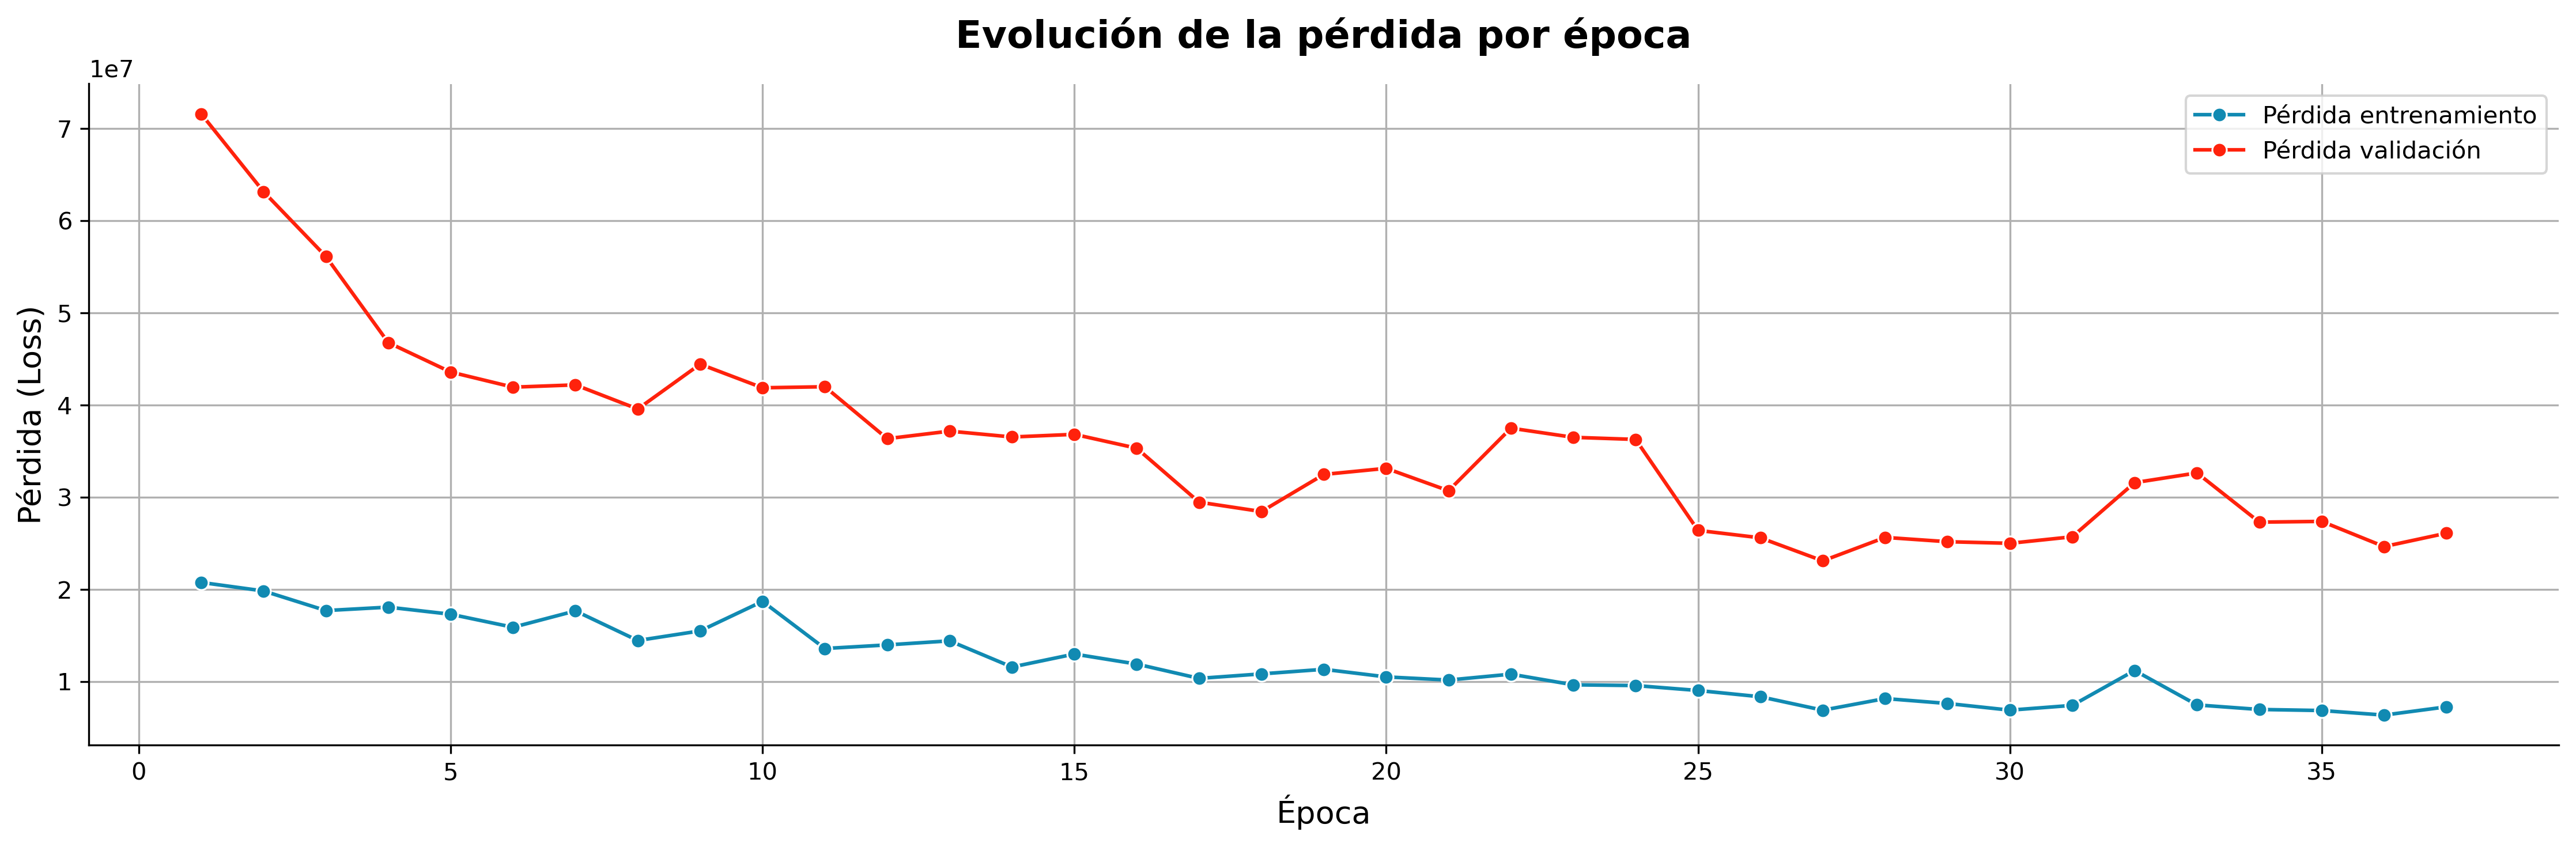

In [15]:
plot_training_history(history)

In [16]:
max(tm_callback.val_tm_history)

0.04399999264142427

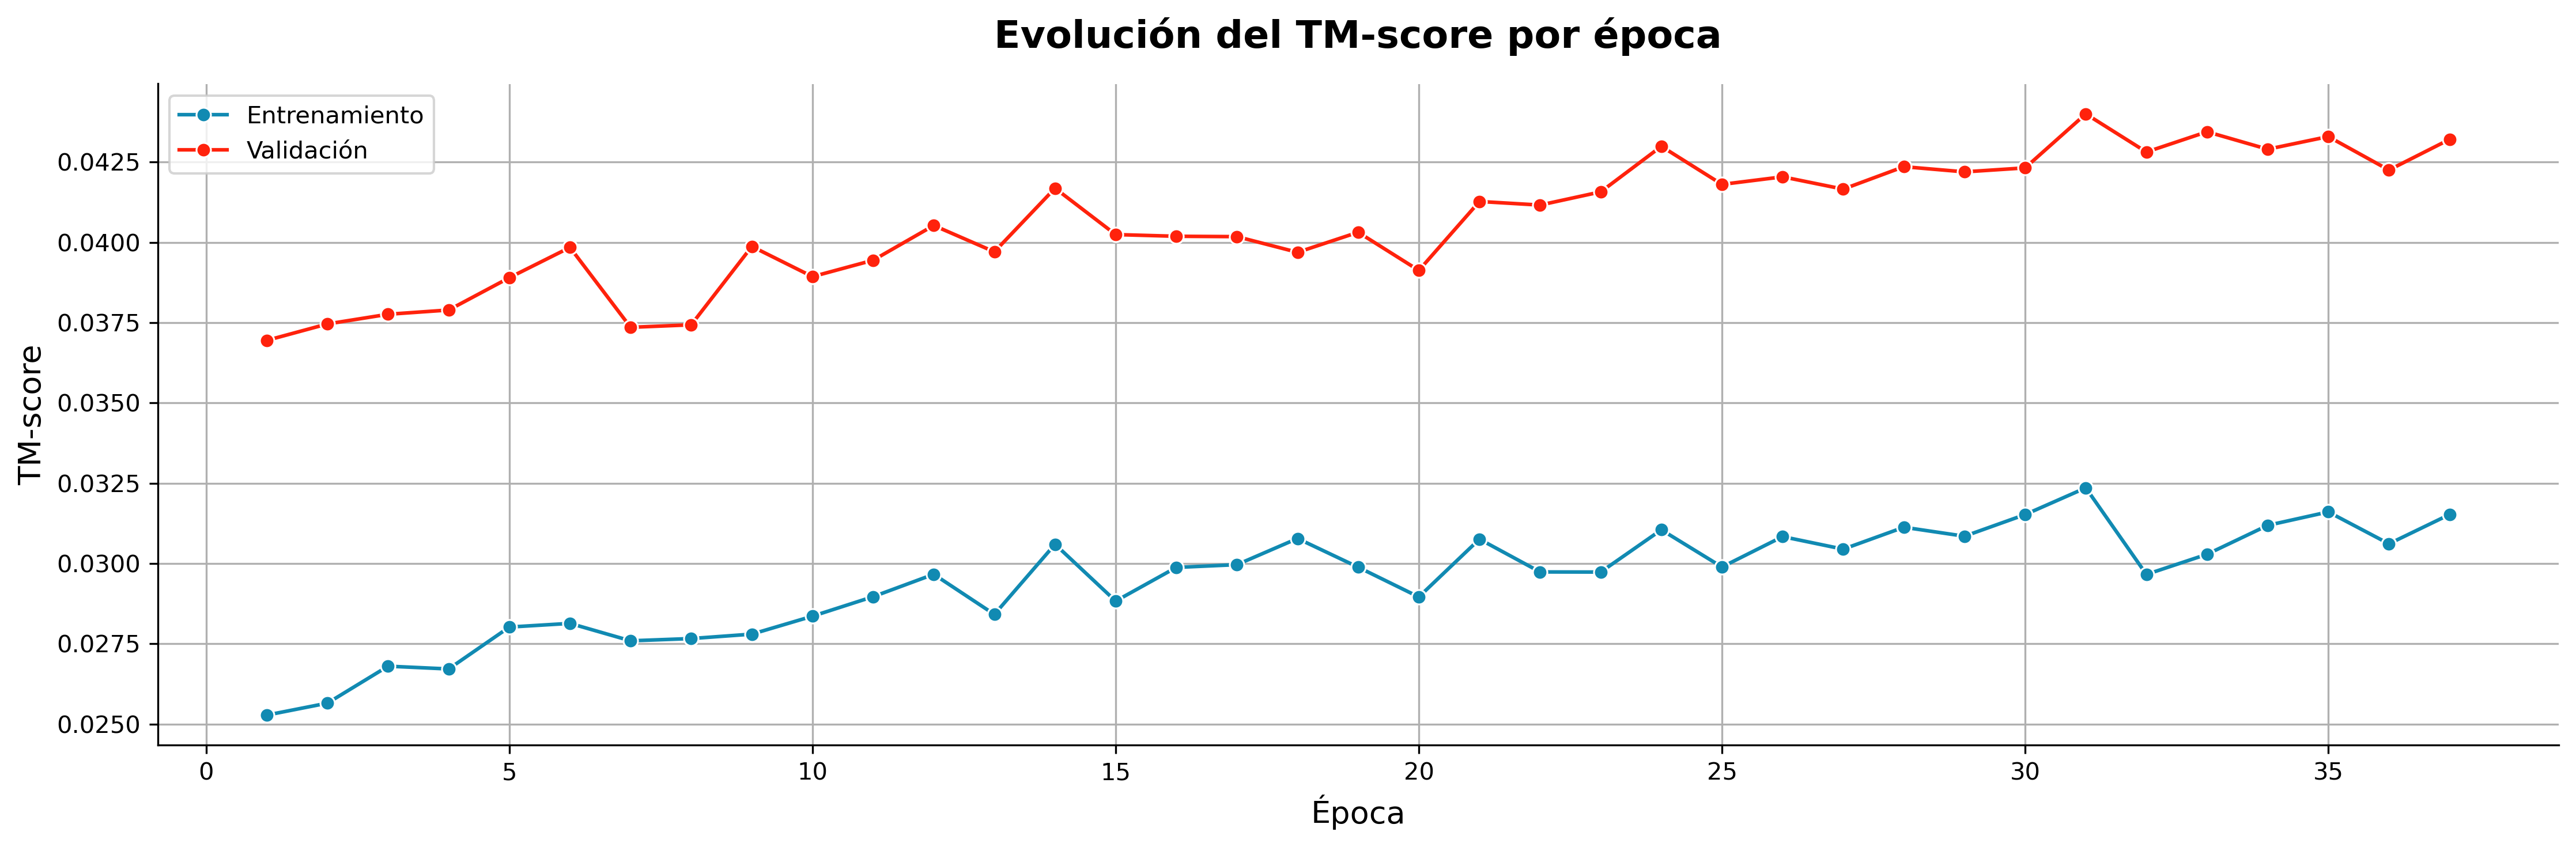

In [18]:
tm_callback.plot_tm_score()

## Inferencia sobre validacion para reporte de resultados 
Aqui tuvimos un problema y es que la competicion cerró el dia que ibamos a hacer la ifnerencia con el modelo final y perdimos acceso a los datos de test. por lo que toco reajustar en dividir los datos de train para obtenre un conjunto de validacion y utilizar el conjunto de validacion como uno de test. Es necesario reiniciar el kernel antes de correr esta parte

In [7]:
embeddings_dict_train = {}
for seq_id in df_train['sequence_id'].unique():
    seq_df = df_train[df_train['sequence_id'] == seq_id]
    sequence = ''.join(seq_df['nucleotide'].values)
    embeddings_dict_train[seq_id] = get_embeddings(sequence, tokenizer, model)

embeddings_dict_test = {}
for seq_id in df_val['sequence_id'].unique():
    seq_df = df_val[df_val['sequence_id'] == seq_id]
    sequence = ''.join(seq_df['nucleotide'].values)
    embeddings_dict_test[seq_id] = get_embeddings(sequence, tokenizer, model)

In [10]:
X_train, y_train = prepare_input_output(df_train, embeddings_dict_train)
X_test, y_test = prepare_input_output(df_val, embeddings_dict_test)



X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
y_train = np.nan_to_num(y_train, nan=0.0, posinf=0.0, neginf=0.0)

X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)
y_test = np.nan_to_num(y_test, nan=0.0, posinf=0.0, neginf=0.0)


print("X_train shape:", X_train.shape)
print("X_val shape:", X_test.shape)

X_train shape: (839, 440, 122)
X_val shape: (12, 440, 122)


In [12]:
input_shape = X_train.shape[1:]  
model = build_conv1d_model(input_shape)
model.compile(optimizer='adam', loss='mape')

model.summary()

/Users/rospel/anaconda3/envs/Project1/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 440, 122)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masking (Masking)               │ (None, 440, 122)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 440, 128)       │       109,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 440, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 440, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 440, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 440, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 440, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 440, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 440, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 440, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 440, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 440, 3)         │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 416,131 (1.59 MB)

 Trainable params: 414,723 (1.58 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [14]:
history = model.fit(
    X_train, y_train,
    epochs=100, batch_size=16,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor= 'loss')]
)

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 7457617.5000
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 7956214.5000
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 7607110.0000
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 11425261.0000
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 7770273.5000
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 11601041.0000
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 6915115.0000
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 8735477.0000
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 5819476.0000
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 5946575.5000
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 4396786.5000
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 6344217.0000
Epoch 13/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 6181903.0000
Epoch 14/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 53

In [16]:
#plot_training_history(history)

In [17]:
y_pred = model.predict(X_test, batch_size=16, verbose=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


/Users/rospel/anaconda3/envs/Project1/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [18]:
tm_scores = []
for true_seq, pred_seq in zip(y_test, y_pred):
    valid_len = np.sum(np.any(true_seq != 0, axis=-1))
    if valid_len == 0:
        continue
    t_true = true_seq[:valid_len]
    t_pred = pred_seq[:valid_len]
    score = compute_tm_score(t_true, t_pred)
    tm_scores.append(score)

mean_tm_score = np.mean(tm_scores)
print(f"TM-score promedio en test: {mean_tm_score:.6f}")

TM-score promedio en test: 0.009869


In [19]:
for i, s in enumerate(tm_scores):
    print(f"Secuencia {i:3d}: TM-score = {s:.5f}")

Secuencia   0: TM-score = 0.01411
Secuencia   1: TM-score = 0.00226
Secuencia   2: TM-score = 0.00867
Secuencia   3: TM-score = 0.00188
Secuencia   4: TM-score = 0.00096
Secuencia   5: TM-score = 0.00056
Secuencia   6: TM-score = 0.00142
Secuencia   7: TM-score = 0.00091
Secuencia   8: TM-score = 0.04190
Secuencia   9: TM-score = 0.04455
Secuencia  10: TM-score = 0.00062
Secuencia  11: TM-score = 0.00059
